# 2.1:  Computer Tomography: Forward Transform
Gruppe: Gabriel Wolf und Jakob Scheiber

In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Winkelbereich und Definitionsbereiche

Zuerst ist der Bereich, in dem $\varphi$ sein kann, gesucht. 

Mit einem Blick auf die Grafik 1 in der Angabe wird klar das sich der Winkel

zwischen 0° und exklusive 180° befinden kann.

Somit folgt $\varphi \in [0;180)$°

Wenn das Foto, bzw der Datensatz die Dimensionen M x N hat kann $\epsilon$ (also die Position entlang des Detektors)
 
 sich zwischen $-\frac{N}{2}$ und $+\frac{N}{2}$ hin und her schieben, also die Gesamte Bildbreite.

Somit folgt $\epsilon \in [-\frac{N}{2} ; \frac{N}{2}  ]$

Analog gilt das auch für $\eta$, nur muss hier bedacht werden, dass $\eta$ auch quer übers ganze Bild bzw. Körper zeigen kann.

Also folgt ganz einfach mit Geometrie $ \eta \in [ -\tfrac{1}{2}\sqrt{M^2 + N^2} ; \tfrac{1}{2}\sqrt{M^2 + N^2}]$


### Unterpunkt b: Evaluate Projections

In [6]:
data =np.loadtxt("Data/ring.txt", delimiter=',') 
print(data.shape) #ahh okay
M = data.shape[0] 
N= data.shape[1]

ksi_interval = np.linspace(-N/2 ,N/2 ,N) #Ksi Intervall
eta_interval = np.linspace(-np.sqrt((M**2)+(N**2))/2, np.sqrt((M**2)+(N**2))/2 ,M) #Eta Intervall
phi_interval = np.linspace(0, 1*np.pi, 180) #Phi Intervall

p_phi = np.zeros((len(phi_interval),len(ksi_interval))) #p array erzeugen
delta_eta = eta_interval[1] - eta_interval[0] #Schrittweite Eta

cx = (N-1) /2 #center x
cy = (M-1) /2  #center y

#Forward transform - 
for p in range(len(phi_interval)):
    phi = phi_interval[p]
    for i in range(N):
        ksi= ksi_interval[i]
        sum = 0
        for j in range(M):
            eta= eta_interval[j]
            x= ksi*np.cos(phi) - eta*np.sin(phi)
            y= ksi*np.sin(phi) + eta*np.cos(phi)
            x_int = int(np.round(x + cx)) 
            y_int = int(np.round(y + cy))
            if 0 <= x_int < N and 0 <= y_int < M: 
                sum= sum+data[y_int,x_int]
        p_phi[p,i] = sum*delta_eta

(360, 360)


### Unterpunkt c: Plotting

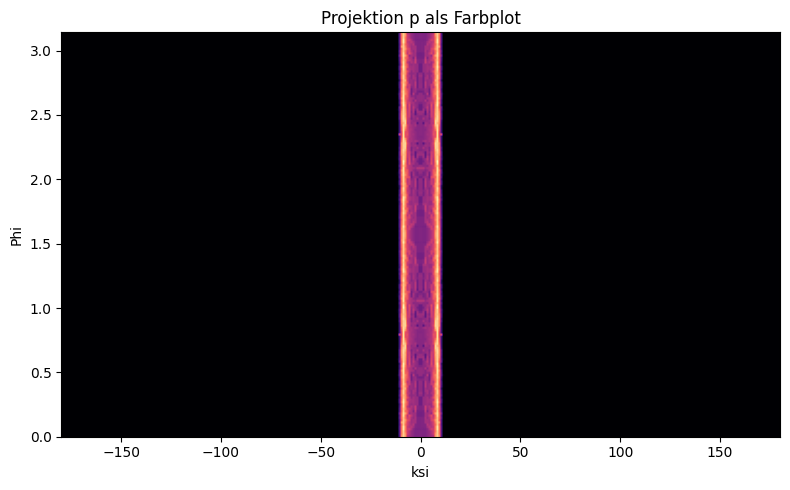

In [7]:
plt.figure(figsize=(8,5))
plt.imshow(
    p_phi,
    extent=[ksi_interval[0], ksi_interval[-1], phi_interval[0], phi_interval[-1]],
    aspect='auto',
    origin='lower',
    cmap='magma'
)
plt.xlabel('ksi')
# plt.xlim(-30,30) # ranzoomen wenn man möchte
plt.ylabel('Phi')
plt.title('Projektion p als Farbplot')
plt.tight_layout()
plt.show()

### Unterpunkt d: Number of steps
Auswirkung der Steps von:

$\xi$: Verschmierung der Kanten der Säule, Schlechte horziontale Auflösung

$\eta$: Gibt die Schrittweite des Linienintegrals an, also analyiert die Genauigkeit

des Intensitätsabfalls, wählt man es zu groß, verschmieren die Farben des plots

bzw. der Abfall wird nicht genau genug aufgenommen.

$\varphi$: Steuert im Endeffekt wie viele Richtungen man projeziert

Minimum wäre bei $\xi$ und $\eta$ jeweils 1 pixel, da ja auch die Auflösung der Daten

nicht höher sein kann. Für $\varphi$ wäre es 1 Grad schätzungsweise (?) nochmal nachchecken sonst

### Unterpunkt e: Fourier components F (kξ cos φ, kξ sin φ)

In [8]:
delta_ksi = ksi_interval[1] - ksi_interval[0]
N_phi = len(phi_interval)
N_ksi = len(ksi_interval)

N_fft = 2**int(np.ceil(np.log2(N_ksi))) #N auf nächste 2er Potenz aufrunden (np.ceil rundet auf) um sicherzugehen dass "grid positions are a power of two"

p_phi_power = np.zeros((N_phi, N_fft), dtype=float) #Matrix (N_phi × N_fft) die etwas Breiter ist als p_phi weil N_fft >= N_ksi (power 2)
p_phi_power[:, :N_ksi] = p_phi #p_phi in die linke obere Ecke von p_phi_power kopieren

F_phi = np.fft.fft(p_phi_power, axis=1) * delta_ksi #fft macht Summe über alle Ksi werte (axis=1) und mit delta_ksi multiplizieren damit aus Summe ein Integral wird

kksi = 2 * np.pi * np.fft.fftfreq(N_fft, d=delta_ksi) #Frequenzen kksi berechnen mit np.fft.fftfreq

F_phi = np.fft.fftshift(F_phi, axes=1) #fft gibt Frequenzen in unsortierter Reihenfolge zurück, mit fftshift sortieren wir sie so dass negative Frequenzen links und positive rechts sind
kksi   = np.fft.fftshift(kksi)

cosphi = np.cos(phi_interval)[:, None]     
sinphi = np.sin(phi_interval)[:, None]     

kx = kksi[None, :] * cosphi                
ky = kksi[None, :] * sinphi   

### Unterpunkt f: Plot

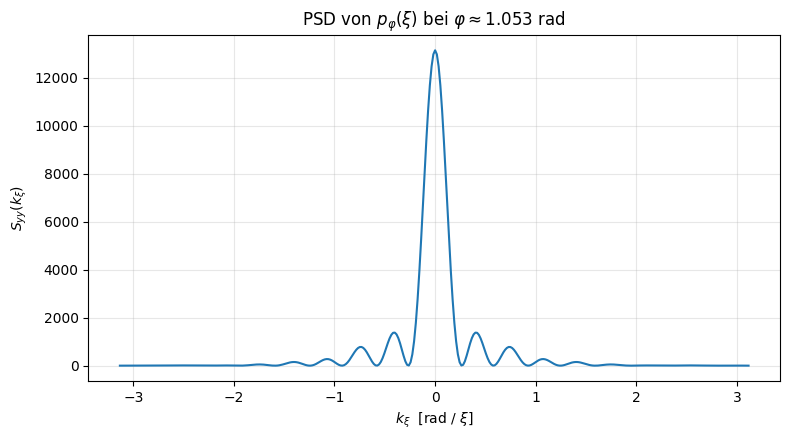

In [9]:
# 1) Wähle einen Winkelindex p (z.B. irgendein Winkel)
p = 60  # z.B. φ ≈ phi_interval[60]
y = p_phi[p, :]              # Projektion p_φ(ξ) für diesen Winkel
N_ksi = y.size
delta_ksi = ksi_interval[1] - ksi_interval[0]

# FFT von y(ξ): F(kξ) ≈ ∑ y(ξ_j) e^{-i kξ ξ_j} Δξ
# (np.fft.fft macht die DFT über das Array y)
F_kxi = np.fft.fft(y) * delta_ksi          


kxi = 2.0 * np.pi * np.fft.fftfreq(N_ksi, d=delta_ksi)   # np.fft.fftfreq gibt Frequenzen f in Zyklen/Δξ, wir wollen k = 2π f


F_kxi_shift = np.fft.fftshift(F_kxi) # Sortieren der Frequenzen
kxi_shift   = np.fft.fftshift(kxi)

# 6) Power Spectral Density S_yy(kξ) nach Gl. (12) 
S = (np.abs(F_kxi_shift)**2) / (N_ksi**2)

# 7) Plot
plt.figure(figsize=(8, 4.5))
plt.plot(kxi_shift, S)
plt.xlabel(r'$k_\xi$  [rad / $\xi$]')
plt.ylabel(r'$S_{yy}(k_\xi)$')
plt.title(rf'PSD von $p_\varphi(\xi)$ bei $\varphi \approx {phi_interval[p]:.3f}$ rad')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri